In [1]:
# import sys
# !python3 -m pip install tqdm

# from platform import python_version
# print(python_version())

In [15]:
# import necessary packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import auc
# from tqdm import tqdm_notebook
# import cv2
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix


# import seaborn as sns 
import matplotlib.pyplot as plt
# import imageio
# import cv2
import math

import matplotlib.image as mpimg
# from PIL import Image
from sklearn import tree
from sklearn.externals import joblib
from sklearn.decomposition import PCA
F_n = 10 # Fold Count

import os
import csv
from random import sample 
import seaborn as sns

### Dimensionality Reduction

0    282682
1     24825
Name: TARGET, dtype: int64


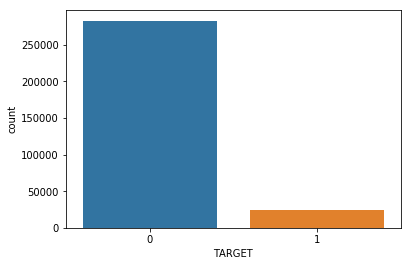

In [9]:
# train_df=pd.read_csv("home_credit_missing_filled_with_mean.csv")

sns.countplot(train_df["TARGET"])
print(train_df['TARGET'].value_counts())
class_label = train_df['TARGET'].values

mat_X_ = train_df.values

np.savetxt('augmented_mat.txt',mat_X_,fmt='%.4f')


### PCA

In [ ]:
# calculate covariance and perform eigenvalue decomposition
def basis(data):
    np.set_printoptions(formatter={'float':"{:6.6g}".format})

    col = len (data.columns)-1
    X = data.iloc[:,0:col].values
    y = data.iloc[:,col].values
    mat_X = np.matrix(X)    
    mu = mat_X.sum(axis = 0)/(len(mat_X)) 
    mean = np.matrix(mu).T
    cls = np.matrix(y).T

    covariance_mat = (mat_X - mu).T.dot((mat_X - mu))/(mat_X.shape[0]-1)
    print (covariance_mat.shape)
    e_values, e_vectors = np.linalg.eig(covariance_mat)
    e_pairs = [(np.abs(e_values[i]), e_vectors[:,i]) for i in range(len(e_values))]

    # sort from high to low
    e_pairs.sort()
    e_pairs.reverse()
    e_val_mat = np.asmatrix(e_values)
    # sort the eigenvalue in the ascending order
    e_val_mat.sort()

    return mat_X, e_vectors, e_val_mat, e_pairs, cls, e_values

mat_X, e_vectors, e_val_mat, e_pairs, cls, e_values= basis (data1)

# derive a new set of basis and choose the major axes with variable error rate
def PCA(eigen_val_mat,eigen_pairs,normalized_data,error_rate):
    psum = 0.0
    nf = np.size(eigen_val_mat,1)
    for i in range (0, nf):
        psum += eigen_val_mat[0, i]
    p = 0
    sum = 0.0
    while sum/psum < error_rate and p < nf:
        sum += eigen_val_mat[0,p]
        p += 1   
    pnf = nf - (p-1)  
    print (pnf)
    matrix_w = np.hstack((eigen_pairs[i][1].reshape(nf,1))for i in range (0,pnf))
    return matrix_w

# Represent the data using this new set of basis for a reduced dimension
def dimension_reduction(W, data):
    col = len (data.columns)-1
    x = data.iloc[:,0:col].values
    y = data.iloc[:,col].values
    mat = np.matrix(x)
    classs = np.matrix(y).T

    reduced_data = (mat.dot(W))
    pX = np.hstack((reduced_data.real,classs))
#     print ('\n Reduced Data: \n', pX)
    return pX

# W = PCA (e_val_mat,e_pairs,mat_X,#)
# pX = dimension_reduction (W, data1 )
# np.savetxt('pFINAL_#.txt',pX,fmt='%.4f')



### FLD

In [ ]:
# calculate the mean-vectors for each class
def mean_vectors(x, y):
    class_ = np.unique(y)
    mean_vectors = []
    for cls in class_:
        mean_vectors.append(np.mean(x[y==cls], axis=0))
    return mean_vectors

# calculate the within class scatter matrix 
def scatter_within(x, y):
    class_ = np.unique(y)
    n_col = x.shape[1]
    mean = mean_vectors(x, y)
    Sw = np.zeros((n_col, n_col))
    for cls, mean_vec in zip(class_, mean):
        Sc = np.zeros((n_col, n_col))                 
        for row in x[y == cls]:
            row, mean_vec = row.reshape(n_col, 1), mean_vec.reshape(n_col, 1)
            Sc += (row-mean_vec).dot((row-mean_vec).T)
        Sw += Sc   
    return Sw

# create W matrix
def create_w (train_data):
    col = len (train_data.columns)-1
    x = train_data.iloc[:,0:col].values
    y = train_data.iloc[:,col].values
    mean_vec = mean_vectors(x, y)
    Sw = scatter_within(x, y)
    W = (np.linalg.inv(Sw)).dot(mean_vec[0]-mean_vec[1])
    W_mat = np.matrix(W).T
    return W_mat
    
# build LDA model with mean and Sw    
def LDA(data, W_mat):
    col = len (data.columns)-1
    x = data.iloc[:,0:col].values
    y = data.iloc[:,col].values
    mat = np.matrix(x)
    classs = np.matrix(y).T

    reduced_data = mat.dot(W_mat)
    fX = np.hstack((reduced_data.real,classs))
#     print ('\n Reduced Data: \n', fX)
    return fX

# W_mat = create_w (data1)
# fX = LDA (data1,W_mat )
# np.savetxt('fFINAL.txt',fX,fmt='%.8f')



### Supervised
### MPP

In [6]:
def gaussian_mle (data,a,b):
    df = pd.DataFrame(data,index = None, columns = list(range (len(data[0]))) )
    df = df.apply(pd.to_numeric)
    col = len (df.columns)-1
    X = df.iloc[:,0:col].values
    Y = df.iloc[:,col].values
        
    class0 = df.loc[(df[col] == 0)]
    class1 = df.loc[(df[col] == 1)]

    col0 = len (class0.columns)-1
    X0 = class0.iloc[:,0:col0].values
    mat0 = np.matrix(X0)    

    col1 = len (class1.columns)-1
    X1 = class1.iloc[:,0:col1].values
    mat1 = np.matrix(X1)  

    class_type = np.unique(Y)
    n_classes = class_type.shape[0]
    mean_vectors = []
    for cls in class_type:
        mean_vectors.append(np.mean(X[Y==cls], axis=0))
    
    mu0 = mean_vectors[0]
    mu1 = mean_vectors[1]
    cov0 = ((mat0 - mu0).T.dot((mat0 - mu0)))/mat0.shape[0]
    cov1 = ((mat1 - mu1).T.dot((mat1 - mu1)))/mat1.shape[0]

    # find covariance matrices for CASE I
    I = np.identity(col)
    sigma3 = cov0[a,b]*I

    cov_vectors = [cov0,cov1,sigma3] 
    dim_data = df.shape[0]
    dim_class0 = class0.shape[0]
    dim_class1 = class1.shape[0]

    return mean_vectors, cov_vectors, dim_data, dim_class0,dim_class1


#implement mpp
def mpp(data_te,mean1,mean2,detClass1,detClass2,invClass1,invClass2,probClass1):
    probClass2 = 1-probClass1
    df = pd.DataFrame(data_te,index = None, columns = list(range (len(data_te[0]))) )
    df = df.apply(pd.to_numeric)
    col = len (df.columns)
    X = df.iloc[:,0:col].values

    # create a matrix from test data for calculation
    testSet = np.matrix(X)

    n = testSet.shape[1]
    
    predictedMatrix = np.zeros((testSet.shape[0], 2))
    
    bestAccuracy = 0
    correctGuesses = 0
    line1 = np.zeros((1, n-1))
    for i in range(testSet.shape[0]):
        for j in range (n-1):
            line1[:,j] = testSet[i,j]

        line2 = line1.T
        mahalanobis = line2 - mean1
        mahalanobis1 = mahalanobis.T
        mahalanobis2 = mahalanobis1 * invClass1
        mahalanobis3 = mahalanobis2 * (line2 - mean1)
        varMahalanobis = float(-0.5 * mahalanobis3[0][0])
        probIsClass1 = float((1.0 / math.sqrt(2 * math.pi * detClass1)) * math.exp(varMahalanobis) * (probClass1))

        mahalanobiss = line2 - mean2
        mahalanobiss1 = mahalanobiss.T
        mahalanobiss2 = mahalanobiss1 * invClass2
        mahalanobiss3 = mahalanobiss2 * (line2 - mean2)
        varMahalanobiss = float(-0.5 * mahalanobiss3[0][0])

        probIsClass2 = float((1.0 / math.sqrt(2 * math.pi * detClass2)) * math.exp(varMahalanobiss) * (probClass2))

        predictedClass = 0
        if probIsClass2 > probIsClass1:
            predictedClass = 1

        if predictedClass == testSet[i,n-1]: 
            correctGuesses+=1

        error = float(min(probIsClass2, probIsClass1))

        predictedMatrix[i][1] = error
        predictedMatrix[i][0] = predictedClass
            
#         print (correctGuesses) 
#     print (len(testSet))
    acc = float(correctGuesses) / float(len(testSet))
    if acc > bestAccuracy:
        bestAccuracy = acc

    return testSet,predictedMatrix, bestAccuracy




### Performance Evaluation

In [10]:
#calculate TP,TN,FP,FN values
def performance_measure(testSet, predictedMatrix):
    n = testSet.shape[1]
    true_class = []
    predicted_class = []

    for i in range(testSet.shape[0]):
        true = testSet[i,n-1]
        true_class.append(true)
        
    for i in range(predictedMatrix.shape[0]):
        predicted = predictedMatrix[i,0]
        predicted_class.append(predicted)
        
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    posneg = []
    for i in range(len(predicted_class)): 
        if true_class[i]==predicted_class[i]==1:
            TP += 1
        if predicted_class[i]==1 and true_class[i]!=predicted_class[i]:
            FP += 1
        if true_class[i]==predicted_class[i]==0:
            TN += 1
        if predicted_class[i]==0 and true_class[i]!=predicted_class[i]:
            FN += 1

    posneg.append(TP)
    posneg.append(FP)
    posneg.append(TN)
    posneg.append(FN)
    
    
    return posneg

#calculate sensitivity,specificity, TPR, FPR
def accuracy(performance_list):
    sensitivity = performance_list[0]/(performance_list[0]+performance_list[3])
    specificity = performance_list[2]/(performance_list[2]+performance_list[1])
    TPR = sensitivity
    FPR = 1 - specificity
    roc = [sensitivity,specificity, TPR, FPR]
    return roc

#calculate accuracy (the probability of a correct decision)
def getAccuracy(performance_list):
    acc = (performance_list[0]+performance_list[2])/sum(performance_list)
    
    return acc



### k-fold split

In [11]:
#K-fold validation on the training set
#split the training set into train and test 
def kfold_split(n_split, x_len):
    index = []
    test_size = int(x_len/n_split)
    train_size = x_len - test_size
    for i in range(n_split):
        j = i*test_size
        index.append([list(set(list(range(0,x_len))).difference(set(list(range(j,j+test_size)))) ),
                     list(range(j,j+test_size))])
    return index


### implement MPP

In [12]:
def openfile (filename):
    fileData1 = open(filename, "r")#,encoding='utf-8-sig')
    lines = fileData1.readlines()

    data = []
    for line in lines:
        x = line.split(',')
        data.append(x)
    return data

def det (mat,n):
    (sign, logdet) = np.linalg.slogdet(mat)
    s = sign * np.exp(logdet/n)
    return s

#get mean accuracy of all K-folds for diffrent k in KNN
def cross_validation_score(trainingSet, n_split,n):
    train = pd.DataFrame(trainingSet)
    col = len (train.columns)
    X = train.iloc[:,0:col].values
    index = kfold_split(n_split, len(X))
    acc1 = []
    acc2 = []
    acc3 = []
    
    t1 = []
    f1 = []
    t2 = []
    f2 = []
    t3 = []
    f3 = []

    count = 0
    for train_index, test_index in index:
        count += 1
        print ('\nfold: ',count)
        
        x = X[train_index]
        y = X[test_index]
        
        # uncomment this line for output
#         print (x.tolist())
        mean_vectors, cov_vectors,dim_data, dim_class0,dim_class1  = gaussian_mle (x.tolist(),0,0)
        mean1 = np.matrix(mean_vectors[0]).T
        mean2 = np.matrix(mean_vectors[1]).T
        cov0 = cov_vectors[0]
        cov1 = cov_vectors[1]
        cov2 = cov_vectors [2]

        # calculate determinant and inverse of new covariance Matrix (case 1: covariance matrices are equal to (sigma^2)I)
        detClass1 = det (cov2,n) #np.linalg.det(cov2)
        detClass2 = detClass1
        invClass1 = np.linalg.inv(cov2)
        invClass2 = invClass1

        # calculate determinant and inverse of new covariance matrices (case 2: covariance matrices is equal)
        detClass12 = det (cov1,n) #np.linalg.det(cov1)
        detClass22 = detClass12
        invClass12 = np.linalg.inv(cov1)
        invClass22 = invClass12
        
        # calculate determinant and inverse of new covariance matrices (case 3: covariance matrices are different)
        detClass13 = det (cov0,n) #np.linalg.det(cov0)
        invClass13 = np.linalg.inv(cov0)
        invClass23 = np.linalg.inv(cov1)
        detClass23 = det (cov1,n) #np.linalg.det(cov1)
#         print (detClass13)
#         print (detClass23)

        testSet1,predictedMatrix1,bestAccuracy1 = mpp(y.tolist(),mean1,mean2,detClass1,detClass2,invClass1,invClass2,dim_class0/dim_data)
        case1 = performance_measure(testSet1, predictedMatrix1)
        per_list1 = accuracy(case1)
        
        classificationAccuracy1 = getAccuracy(case1)
        tpr1 = accuracy(per_list1)[2]
        fpr1 = accuracy(per_list1)[3]
        t1.append(tpr1)
        f1.append(fpr1)
        print ("\nCASE I")
        print (classificationAccuracy1)
        acc1.append(classificationAccuracy1)
#         class_acc1+=bestAccuracy1
        
        testSet2,predictedMatrix2,bestAccuracy2 = mpp(y.tolist(), mean1,mean2,detClass12,detClass22,invClass12,invClass22,dim_class0/dim_data)
        case2 = performance_measure(testSet2, predictedMatrix2)
        per_list2 = accuracy(case2)
        classificationAccuracy2 = getAccuracy(case2)
        roc2 = accuracy(per_list2)
        tpr2 = accuracy(per_list2)[2]
        fpr2 = accuracy(per_list2)[3]
        t2.append(tpr2)
        f2.append(fpr2)
        print ("\nCASE II")
        print (classificationAccuracy2)
#         print (bestAccuracy2)
        
        acc2.append(classificationAccuracy2)
#         class_acc2+=bestAccuracy2

        testSet3,predictedMatrix3,bestAccuracy3 = mpp(y.tolist(),mean1,mean2,detClass13,detClass23,invClass13,invClass23,dim_class0/dim_data)
        case3 = performance_measure(testSet3, predictedMatrix3)
        per_list3 = accuracy(case3)
        tpr3 = accuracy(per_list3)[2]
        fpr3 = accuracy(per_list3)[3]

        classificationAccuracy3 = getAccuracy(case3)
        roc3 = accuracy(per_list3)
        t3.append(tpr3)
        f3.append(fpr3)
        print ("\nCASE III")
        print (classificationAccuracy3)
        acc3.append(classificationAccuracy3)

    avg1 = (sum(acc1)/len(acc1))*100
    print('\n CASE I accuracy: ',avg1)
    print ('\n CASE I TPR: ', t1)
    print ('\n CASE I FPR: ', f1)

    avg2 = (sum(acc2)/len(acc2))*100
    print('\n CASE II accuracy: ',avg2)
    print ('\n CASE II TPR: ', t2)
    print ('\n CASE II FPR: ', f2)

    avg3 = (sum(acc3)/len(acc3))*100
    print('\n CASE III accuracy: ',avg3)
    print ('\n CASE III TPR: ', t3)
    print ('\n CASE III FPR: ', f3)

    return avg1,avg2,avg3

# data2 = openfile ('pFINAL_.01.txt')
# cross_validation_score(data2, 5,100)


In [14]:
data = openfile ('augmented_mat.txt')

cross_validation_score(data, 5,100)



fold:  1


ValueError: ('Unable to parse string "61501.0000 171329.0000 0.0000 0.0000 1.0000 0.0000 0.0000 180000.0000 409500.0000 32350.5000 409500.0000 0.0182 -11371.0000 -2645.0000 -5319.0000 -3776.0000 15.0000 1.0000 1.0000 0.0000 1.0000 1.0000 0.0000 2.0000 3.0000 3.0000 13.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5021 0.3911 0.2021 0.1072 0.1858 0.9866 0.8164 0.0161 0.0000 0.2759 0.1667 0.2083 0.1033 0.0874 0.1107 0.0000 0.0000 0.1092 0.1928 0.9866 0.8236 0.0162 0.0000 0.2759 0.1667 0.2083 0.1057 0.0955 0.1153 0.0000 0.0000 0.1083 0.1858 0.9866 0.8189 0.0162 0.0000 0.2759 0.1667 0.2083 0.1051 0.0889 0.1127 0.0000 0.0000 0.0958 0.0000 0.0000 0.0000 0.0000 -1670.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 2.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.2326 0.4396 90000.0000 0.1797 0.0790 2.2750 -1359.0000 -23.0000 -616.0000 266086.8889 -993.0000 9899.0000 1611.7000 9211548.4556 -905.0000 -20.0000 -350.2000 167945.9556 0.0000 0.0000 0.0000 0.0000 0.0000 1696.5000 424.1250 719528.0625 0.0000 1260000.0000 435531.1500 180157681953.2249 4355311.5000 0.0000 435942.0000 94292.2500 29149644137.1750 565753.5000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 207.0000 0.5000 5.0000 0.0000 0.0000 0.5000 5.0000 0.0000 0.0000 0.0000 0.0000 1.0000 10.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.8000 8.0000 0.2000 2.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 -513.0000 -23.0000 -160.8000 44440.2000 708.0000 1798.0000 1265.2000 217491.7000 -45.0000 -20.0000 -27.6000 105.3000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 45000.0000 981000.0000 347712.3000 166595795856.4500 1738561.5000 0.0000 435942.0000 141438.3750 39691711818.5625 565753.5000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 28.0000 -1359.0000 -834.0000 -1071.2000 36237.7000 -993.0000 9899.0000 1958.2000 20208336.7000 -905.0000 -75.0000 -672.8000 117596.2000 0.0000 0.0000 0.0000 0.0000 0.0000 1696.5000 565.5000 0.0000 1260000.0000 523350.0000 219478612500.0000 2616750.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 179.0000 8611.3350 10986.3450 9798.8400 2820336.2501 106654.5000 119938.5000 113296.5000 88232328.0000 85320.0000 119938.5000 102629.2500 599220271.1250 1.0000 1.2501 1.1250 0.0313 0.0000 21334.5000 10667.2500 227580445.1250 106654.5000 119938.5000 113296.5000 88232328.0000 14.0000 16.0000 15.0000 2.0000 0.0000 0.2179 0.1089 0.0237 -1670.0000 -229.0000 -949.5000 1038240.5000 12.0000 12.0000 12.0000 0.0000 24.0000 0.0000 0.0000 1.0000 2.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 2.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 2.0000 0.0000 0.0000 0.0000 0.0000 1.0000 2.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 2.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.5000 1.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 2.0000 0.0000 0.0000 0.0000 0.0000 1.0000 2.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.5000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 8611.3350 10986.3450 9798.8400 2820336.2501 106654.5000 119938.5000 113296.5000 88232328.0000 85320.0000 119938.5000 102629.2500 599220271.1250 1.0000 1.2501 1.1250 0.0313 0.0000 21334.5000 10667.2500 227580445.1250 106654.5000 119938.5000 113296.5000 88232328.0000 14.0000 16.0000 15.0000 2.0000 0.0000 0.2179 0.1089 0.0237 -1670.0000 -229.0000 -949.5000 1038240.5000 12.0000 12.0000 12.0000 0.0000 24.0000 213832.6498 388400.3682 295891.1004 240267.3266 434778.8206 331420.6578 0.8680 inf inf 256229.7745 417968.3891 333971.9569 11.6039 13.2713 12.4195 -983.9386 -728.6427 -847.7647 48.7154 -54.0000 -3.0000 -36.0556 18.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.8333 15.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.1111 2.0000 0.0000 0.0000 0.0000 0.0000 0.0556 1.0000 0.0000 0.0000 0.0000 0.0000 18.0000 2.0000 0.0000 0.0000 0.0000 0.0000 2.0000 55.0000 14.9333 224.0000 1.0000 1.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 8611.3350 71147.0700 14677.8840 220168.2600 8611.3350 71147.0700 14677.8840 220168.2600 -1655.0000 -122.0000 -1224.1333 -18362.0000 15.0000\n" at position 0', 'occurred at index 0')

### Unsupervised
### k-means

In [16]:
def openfile (filename):
    fileData1 = open(filename, "r")#,encoding='utf-8-sig')
    lines = fileData1.readlines()

    data = []
    for line in lines:
        x = line.split()
        data.append(x)
    n = len(data[0])-1
    df1 = pd.DataFrame(data)
    df = df1[df1.columns[:-1]]
    df = df.apply(pd.to_numeric)
    d = df1[[n]].copy()
    cls = d[n]
    col=len(df)
    A = df.iloc[:,0:col].values

    return A,cls

def euclidean_dist(point1, point2):
    d = np.sum(np.square(point2-point1))
    return (np.sqrt(d))

"""Takes the X matrix and the centroids. Then measures the shortest 
distances between them and returns a vector of cluster indices per sample in X"""
def closest_centroids(X, centroid):
    id_ = np.zeros((X.shape[0],1))
    
    #Loop through each sample in X
    for x in range(id_.shape[0]):
        point = X[x]
        #measure distance of this point from each centroid,
        #Keep track of shortest distance and index of shortest distance
        min_dist, idx = 255, 0
        for i in range(centroid.shape[0]):
            centroid_ = centroid[i]
            dist = euclidean_dist(centroid_,point)
            if dist < min_dist:
                min_dist = dist
                idx = i
        #modify the index vector with new id
        id_[x] = idx
        
    return id_


"""Takes X matrix and index vector to compute new centroids"""
def new_centroids(X, id_):
    new = []
    for x in range(len(np.unique(id_))):
        new.append(np.array([X[i] for i in range(X.shape[0]) if id_[i] == x]))
    return np.array([np.mean(y,axis=0) for y in new])


"""Implement k-means all at once """
def kmeans(X, initial_centroids, k,n_iter):
    current_centroids = initial_centroids
    id_ = closest_centroids(X,current_centroids)
    current_centroids = new_centroids(X,id_)
    curr_cent = np.array (current_centroids)
    prev_cent = np.array(initial_centroids)
#     print (curr_cent)
    ite = 0
    while not np.array_equal (prev_cent,curr_cent) and ite < n_iter:
        ite += 1
        print (ite)
        prev_centroids = []
        prev_centroids.append(current_centroids)
        prev_cent = np.array(prev_centroids)
        id_ = closest_centroids(X,current_centroids)
        current_centroids = new_centroids(X,id_)
        curr_cent = np.array (current_centroids)
        
    return id_, prev_centroids

"""Initialize k random centroids"""
def k_random_centroids(X, k):
    random_indices = sample(range(0,X.shape[0]),k)
    return np.array([X[i] for i in random_indices])


def clustering(A,k,n_iter):
    id_, prev_centroids = kmeans(A,k_random_centroids(A,k), k,n_iter)
    id_ = closest_centroids(A, prev_centroids[-1])
    return id_

#calculate TP,TN,FP,FN values
def performance_measure(true_label, clustered_output):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    posneg = []
    for i in range(len(clustered_output)): 
        if true_label[i]==clustered_output[i]==1:
            TP += 1
        if clustered_output[i]==1 and true_label[i]!=clustered_output[i]:
            FP += 1
        if true_label[i]==clustered_output[i]==0:
            TN += 1
        if clustered_output[i]==0 and true_label[i]!=clustered_output[i]:
            FN += 1

    posneg.append(TP)
    posneg.append(FP)
    posneg.append(TN)
    posneg.append(FN)
    
    confusion_mat = np.array([[TN,FP],[FN,TP]])
    return posneg, confusion_mat


#calculate sensitivity,specificity, TPR, FPR
def perf_list(true_label, clustered_output):
    performance_list,confusion_mat = performance_measure(true_label, clustered_output)
    sensitivity = performance_list[0]/(performance_list[0]+performance_list[3])
    specificity = performance_list[2]/(performance_list[2]+performance_list[1])
    TPR = sensitivity
    FPR = 1 - specificity
    roc = [sensitivity,specificity, TPR, FPR]
    return roc


#calculate accuracy (the probability of a correct decision)
def accuracy_score(true_label, clustered_output):
    performance_list,confusion_mat = performance_measure(true_label, clustered_output)
    acc = (performance_list[0]+performance_list[2])/sum(performance_list)
    return acc, confusion_mat

def ground_truth(label):
    true_label = (label.apply(pd.to_numeric)).tolist()
    return true_label

def accuracy (filename):
    A,label = openfile(filename)
    predictions = clustering (A,2,10)
    km_out = [x[0] for x in predictions.tolist()]
    km_output_changed = (pd.DataFrame(km_out)).replace([1, 0], [0, 1])
    km_output_changed = [x[0] for x in km_output_changed.values.tolist()]
    true_label = ground_truth(label)
    roc_org = perf_list(true_label, km_out)
    roc_chng = perf_list(true_label, km_output_changed)
    ac_result,confusion_mat_org = accuracy_score(true_label, km_out)
    ac_manipulated,confusion_mat_manipulated = accuracy_score(true_label, km_output_changed)
    print ('ROC_org: ', roc_org)
    print ('ROC_flipped: ', roc_chng)
    print ('accuracy_result: ',ac_result*100)
    print ('accuracy_manipulated_result: ',ac_manipulated*100)
    return ac_result*100,ac_manipulated*100


# accuracy('fFINAL.txt')


### winner-take-all

In [17]:
def euclidean_dist(point1, point2):
    d = np.sum(np.square(point2-point1))
    return (np.sqrt(d))

def closest_centroids_winner(X, centroid,k):
    id_ = np.zeros((X.shape[0],1))
    id_ = np.zeros((X.shape[0],1))
    #Loop through each data point in X

    for x in range(id_.shape[0]):
        point = X[x]
        #Compare this point to each centroid,
        #Keep track of shortest distance and index of shortest distance
        min_dist, idx = 255, 0
        for i in range(k):
            if centroid is None:
                random_indices = sample(range(0,X.shape[0]),k)
                centroid = np.array([X[i] for i in random_indices])
                centroid_ = centroid[i] 
            elif centroid[i].size==0:
                centroid[i] = np.zeros((1,3))
                centroid_ = centroid[i] 
            else:
                centroid_ = centroid[i]
            dist = euclidean_dist(centroid_,point)
            if dist < min_dist:
                min_dist = dist
                idx = i
#         print (centroid_)
        #With the best index found, modify the result idx vector
        id_[x] = idx
                
    return id_


# calculate new centroids
def new_centroids_winner(X, id_,prev_centroids,k):
    prev_cen = prev_centroids[0].tolist()
    n = k
    new = []
    for x in range(n):
        a = [X[i] for i in range(X.shape[0]) if id_[i] == x]
        new.append(a)
    
    
    new_cen = []
    for x in range (n):
        new_ = []
        for y in new[x]:
            part1 = np.array(prev_cen[x])
            part2_ = y-part1
            part2 = 0.001*part2_
            new__ = part1 + (part2)
            new_.append(np.array(new__))
        mean =  np.array([sum(y)/len(y) for y in new_])
#         print (mean)
        new_cen.append(mean)
#     print (new_cen)
    return np.array(new_cen)

# Implement winner-take-all all at once
def winner_take_all(X, initial_centroids, k, n_iter):
    prev_centroids = []
    current_centroids = initial_centroids
    prev_centroids.append(current_centroids)
    prev_cent = np.array(prev_centroids)
    id_ = closest_centroids_winner(X,current_centroids,k)
    current_centroids = new_centroids_winner(X,id_,prev_centroids,k)
    curr_cent = np.array(current_centroids)
    
    ite = 0
    while not np.array_equal (prev_cent,curr_cent) and ite < n_iter:
        ite += 1
        print (ite)
        prev_centroids = []
        current_centroids = initial_centroids
        prev_centroids.append(current_centroids)
        prev_cent = np.array(prev_centroids)
        id_ = closest_centroids_winner(X,current_centroids,k)
        current_centroids = new_centroids_winner(X,id_,prev_centroids,k)
#         print (prev_centroids)
        curr_cent = current_centroids

#     print (prev_centroids)
    return id_, prev_centroids


    
"""Initialize k random centroids"""
def k_random_centroids(X, k):
    random_indices = sample(range(0,X.shape[0]),k)
    return np.array([X[i] for i in random_indices])


def clustering_winner(A,k,n_iter):
    id_, prev_centroids = winner_take_all(A,k_random_centroids(A,k), k,n_iter)
    id_ = closest_centroids(A, prev_centroids[-1])
    return id_


def accuracy_winner (filename):
    A,label = openfile(filename)
    predictions = clustering_winner (A,2,10)
    km_out = [x[0] for x in predictions.tolist()]
    km_output_changed = (pd.DataFrame(km_out)).replace([1, 0], [0, 1])
    km_output_changed = [x[0] for x in km_output_changed.values.tolist()]
    true_label = ground_truth(label)
    roc_org = perf_list(true_label, km_out)
    roc_chng = perf_list(true_label, km_output_changed)
    ac_result = accuracy_score(true_label, km_out)
    ac_manipulated = accuracy_score(true_label, km_output_changed)
    print ('ROC_org: ', roc_org)
    print ('ROC_flipped: ', roc_chng)
    print ('accuracy_result: ',ac_result*100)
    print ('accuracy_manipulated_result: ',ac_manipulated*100)
    return ac_result*100,ac_manipulated*100

# accuracy_winner ('cactus_mat.txt')

### SOM

In [18]:
def euclidean_dist_(point1,point2):
    difference = point1-point2
    if (difference.ndim ==1):
        return np.abs(difference)
    return np.linalg.norm(difference,axis = 1)

# function for SOM
def SOM (A, variance, min_eps, max_eps, k):
    min_ = 0
    max_ = 255
    n_iter = 10
    sqrt_k = int (np.ceil(np.sqrt(k)))
    prev_centroids  = np.array([0 for j in range(len(A))])
    new_A = np.array([1 for j in range(len(A))])
    
    # create grid of centroids
    new_centroids = np.array([[np.random.uniform(min_, max_) for i in range (len(A[0]))]for j in range(k)])
    indices = np.array([ind for ind in range(k)])

    new_centroids = np.array(new_centroids)
    ite = 0
    while not np.array_equal(prev_centroids,new_A) and ite < n_iter:
        prev_centroids = np.copy(new_A)
        
        ite += 1
        print (ite)
        epsilon = max_eps*(min_eps/max_eps)**(ite/n_iter)
        for i in range(0,len(A)):
            distance = euclidean_dist_(new_centroids,A[i])
            n = np.column_stack((indices,distance))
            n = n[n[:,1].argsort()]
            cluster_indices = int(n[0,0])            
            n = n[n[:,1] <= variance]
            for j in range(len(n)):
                phi = np.exp(-np.linalg.norm(new_centroids[int(n[j,0])]-new_centroids[cluster_indices])**2/(2*variance**2))
                new_centroids[int(n[j,0])] = new_centroids[int(n[j,0])]+epsilon*phi*(np.subtract(A[i],new_centroids[cluster_indices]))
                
            new_A [i] = cluster_indices

    new_centroids = np.array([[int(np.round(new_centroids[j,i]))for i in range(len(A[0]))]for j in range(k)])
    return np.array(new_A),new_centroids
    

def clustering_SOM(A,k):
    new_A,new_centroids = SOM (A, 10.0, 0.0001,0.1,k)
    print (new_A)
    return new_A

def accuracy_som (filename):
    A,label = openfile(filename)
    km_out = clustering_SOM (A,2)
#     print(predictions)
#     km_out = [x[0] for x in predictions.tolist()]
    km_output_changed = (pd.DataFrame(km_out)).replace([1, 0], [0, 1])
    km_output_changed = [x[0] for x in km_output_changed.values.tolist()]
    true_label = ground_truth(label)
    roc_org = perf_list(true_label, km_out)
    roc_chng = perf_list(true_label, km_output_changed)
    ac_result = accuracy_score(true_label, km_out)
    ac_manipulated = accuracy_score(true_label, km_output_changed)
    print ('ROC_org: ', roc_org)
    print ('ROC_flipped: ', roc_chng)
    print ('accuracy_result: ',ac_result*100)
    print ('accuracy_manipulated_result: ',ac_manipulated*100)
    return ac_result*100,ac_manipulated*100

# accuracy_som('fFINAL.txt')

### BKS Fusion

In [ ]:
def BKS(confusionMat1, confusionMat2,predicted1,predicted2):
    clf1 = openfile (confusionMat1)
    clf2 = openfile (confusionMat2)
    clf1_out = openfile_mpp(predicted1)
    clf2_out = openfile(predicted2)
    clf1_predicted = [int(x[0]) for x in clf1_out]
    clf2_predicted = [int(x[0]) for x in clf2_out]
    
    class0 = []
    for i in range (2):
        for x in clf2[0]:
            class0.append(int(clf1[0][i])+int(x)) 

#     print (class0)

    class1 = []
    for i in range (2):
        for x in clf2[1]:
            class1.append(int(clf1[1][i])+int(x)) 

#     print (class1)
    
    fused_label = np.zeros((1,4))
    for i in range (4):
        if class0[i] > class1[i]:
            fused_label[0,i] = 0
        else:
            fused_label[0,i] = 1

#     print (fused_label)
    new_label = np.zeros((len(clf1_predicted),1))

    for i in range (len(clf1_predicted)):
        if clf1_predicted[i] == 0 and clf2_predicted[i] == 0:
            new_label[i,0] = fused_label[0,0]
        elif clf1_predicted[i] == 0 and clf2_predicted[i] == 1:
            new_label[i,0] = fused_label[0,1]
        elif clf1_predicted[i] == 1 and clf2_predicted[i] == 0:
            new_label[i,0] = fused_label[0,2]
        elif clf1_predicted[i] == 1 and clf2_predicted[i] == 1:
            new_label[i,0] = fused_label[0,3]
            
    return new_label

# new_label1 = BKS('f_knn.csv', 'f_dt.csv','f_knn_pred.csv','f_dt_pred.csv')
# accuracy_score (testSet, new_label1)